In [1]:
from typing import Optional, Callable
from numpy.typing import NDArray

from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from bidding_train_env.utils import get_root_path

data_path = get_root_path() / "data/traffic/data_gen_efficient_repr"

advertiser_metadata = pd.read_csv(
    data_path / 'advertiser_data.csv',
    index_col='advertiserNumber'
)

bidding_data = pd.read_parquet(data_path / f'bidding-period-8.parquet')

impression_data = pd.read_parquet(data_path / f'impression_data.parquet')


In [2]:
bidding_data.head()

advertiserNumber             0                               1               \
                         pValue pValueSigma       bid    pValue pValueSigma   
timeStepIndex pvIndex                                                         
0             0        0.000000         0.0  0.000000  0.000173         0.0   
              1        0.000210         0.0  0.003150  0.000646         0.0   
              2        0.000663         0.0  0.009942  0.000586         0.0   
              3        0.000194         0.0  0.002911  0.000767         0.0   
              4        0.001015         0.0  0.015231  0.001309         0.0   

advertiserNumber                       2                               3   \
                            bid    pValue pValueSigma       bid    pValue   
timeStepIndex pvIndex                                                       
0             0        0.000173  0.000063         0.0  0.000063  0.000313   
              1        0.000646  0.000104         0.0  0.000104  0.000382   
              2        0.000586  0.000199         0.0  0.000199  0.000269   
              3        0.000767  0.000061         0.0  0.000061  0.000259   
              4        0.001309  0.000228         0.0  0.000228  0.000270   

advertiserNumber       ...        44        45                        \
                       ...       bid    pValue pValueSigma       bid   
timeStepIndex pvIndex  ...                                             
0             0        ...  0.035695  0.000257         0.0  0.015978   
              1        ...  0.027986  0.000268         0.0  0.016683   
              2        ...  0.020273  0.000315         0.0  0.019563   
              3        ...  0.026407  0.000318         0.0  0.019753   
              4        ...  0.012832  0.000287         0.0  0.017833   

advertiserNumber             46                              47              \
                         pValue pValueSigma       bid    pValue pValueSigma   
timeStepIndex pvIndex                                                         
0             0        0.000617         0.0  0.041453  0.000314         0.0   
              1        0.000168         0.0  0.011320  0.000248         0.0   
              2        0.000491         0.0  0.032984  0.000091         0.0   
              3        0.000708         0.0  0.047592  0.000352         0.0   
              4        0.000689         0.0  0.046310  0.000302         0.0   

advertiserNumber                 
                            bid  
timeStepIndex pvIndex            
0             0        0.030992  
              1        0.024495  
              2        0.008953  
              3        0.034774  
              4        0.029839  

[5 rows x 144 columns]

In [3]:
impression_data.head()

adSlot                                                   1            \
                                          advertiserNumber      cost   
deliveryPeriodIndex timeStepIndex pvIndex                              
7                   0             0                     41  0.098739   
                                  1                     41  0.121738   
                                  2                     38  0.082699   
                                  3                     47  0.119417   
                                  4                     41  0.120777   

adSlot                                                                \
                                          isExposed conversionAction   
deliveryPeriodIndex timeStepIndex pvIndex                              
7                   0             0            True            False   
                                  1            True            False   
                                  2            True            False   
                                  3            True             True   
                                  4            True            False   

adSlot                                                   2            \
                                          advertiserNumber      cost   
deliveryPeriodIndex timeStepIndex pvIndex                              
7                   0             0                     46  0.095737   
                                  1                     47  0.087425   
                                  2                     39  0.077997   
                                  3                      4  0.100235   
                                  4                     42  0.113554   

adSlot                                                                \
                                          isExposed conversionAction   
deliveryPeriodIndex timeStepIndex pvIndex                              
7                   0             0           False            False   
                                  1            True            False   
                                  2            True            False   
                                  3            True            False   
                                  4            True            False   

adSlot                                                   3            \
                                          advertiserNumber      cost   
deliveryPeriodIndex timeStepIndex pvIndex                              
7                   0             0                     47  0.089335   
                                  1                     43  0.084455   
                                  2                     41  0.075048   
                                  3                     41  0.095846   
                                  4                      4  0.089787   

adSlot                                                                
                                          isExposed conversionAction  
deliveryPeriodIndex timeStepIndex pvIndex                             
7                   0             0           False            False  
                                  1            True            False  
                                  2            True            False  
                                  3           False            False  
                                  4            True            False

In [4]:
advertiser_metadata.head()

,advertiserCategoryIndex,budget,CPAConstraint
advertiserNumber,,,
0,0,2900.0,100.0
1,0,4350.0,70.0
2,0,3000.0,90.0
3,0,2400.0,110.0
4,0,4800.0,60.0


In [5]:
pValues = bidding_data.loc[:, bidding_data.columns.get_level_values(1) == 'pValue'].to_numpy().T
pValuesSigma = bidding_data.loc[:, bidding_data.columns.get_level_values(1) == 'pValueSigma'].to_numpy().T

<Axes: >

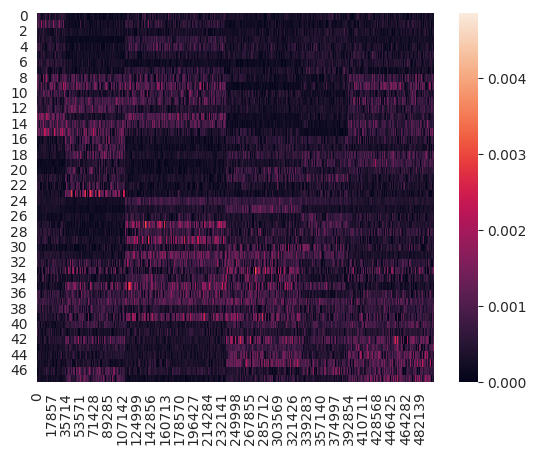

In [6]:
sns.heatmap(pValues)

## Analysis 1: P-values distribution


We want to investigate the following questions:
- Is there a distribution of p-values within a timestap for an advertiser?
- Is there a distribution of p-values over all timesptaps for an advertiser?
- Is the mean and median p-values of the advertisers close?
- This things can change varying the category?

In [7]:
###  Is there a distribution of p-values within a timestap for an advertiser?

def analysis1_1(
    bidding_data: pd.DataFrame,
    advertiser_number: int,
    time_step_index: int,

):
    
    filtered_df = bidding_data[advertiser_number].loc[time_step_index]

    median_pValue = filtered_df['pValue'].median()
    mean_pValue = filtered_df['pValue'].mean()
    std_pValue = filtered_df['pValue'].std()

    print(f"Advertiser {advertiser_number}, Timestep {time_step_index}")
    print(f"Median pValue: {median_pValue}")
    print(f"Mean pValue: {mean_pValue}")
    print(f"Standard deviation: {std_pValue}")

    plt.hist(filtered_df['pValue'], bins=10, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of pValue for timeStepIndex {time_step_index}')
    plt.xlabel('pValue')
    plt.ylabel('Frequency')
    plt.grid(True)




In [8]:
def analysis1_1_comp(
    bidding_data_1: pd.DataFrame,
    bidding_data_2: pd.DataFrame,
    advertiser_number_1: int,
    time_step_index_1: int,
    advertiser_number_2: int,
    time_step_index_2: int,

):
    
    filtered_df_1 = bidding_data_1[advertiser_number_1].loc[time_step_index_1]
    filtered_df_2 = bidding_data_2[advertiser_number_2].loc[time_step_index_2]

    min_edge = min(filtered_df_1['pValue'].min(), filtered_df_2['pValue'].min())
    max_edge = max(filtered_df_1['pValue'].max(), filtered_df_2['pValue'].max())

    # Define common bin edges
    bins = np.linspace(min_edge, max_edge, 2000) 


    plt.hist(filtered_df_1['pValue'], bins=bins, color='blue', edgecolor='black', alpha=0.7)
    plt.hist(filtered_df_1['pValue'], bins=bins, color='orange', edgecolor='black', alpha=0.7)
    plt.title(f'Advertiser {advertiser_number_1} - Timestep {time_step_index_1} vs. Advertiser {advertiser_number_2} - Timestep {time_step_index_2}')
    plt.xlabel('pValue')
    plt.ylabel('Frequency')
    plt.grid(True)


Advertiser 0, Timestep 0
Median pValue: 0.0004733848770306
Mean pValue: 0.0004797280510026968
Standard deviation: 0.00027166517154536936


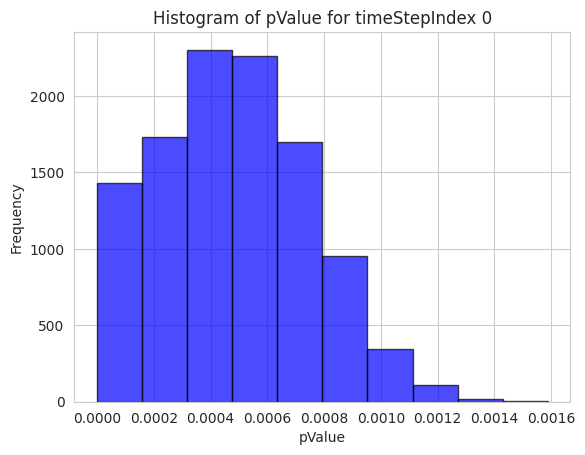

In [9]:
analysis1_1(bidding_data, 0, 0)


Advertiser 0, Timestep 10
Median pValue: 0.0001916534776291
Mean pValue: 0.0001921685968419498
Standard deviation: 7.664445244938256e-05


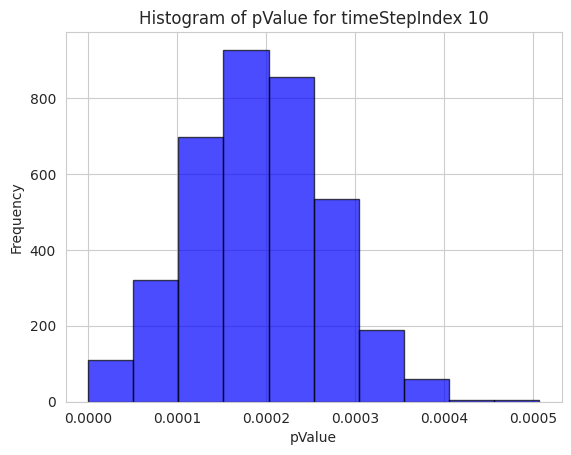

In [35]:
analysis1_1_comp(bidding_data=bidding_data, 
                    advertiser_number=0, 
                    time_step_index=0, 
                    )

Advertiser 10, Timestep 0
Median pValue: 0.0009007577145939
Mean pValue: 0.0009013507721959208
Standard deviation: 0.00031615513497246575


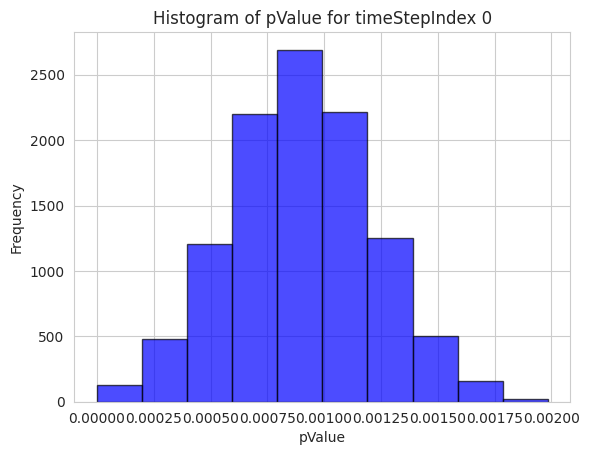

In [36]:
analysis1_1(bidding_data, 10, 0)